In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

# Environment Setup

In [3]:
class StochasticPricingEnvironment:
    """
    Stochastic environment with a distribution over customer valuations for a single product.
    The demand probability depends on the price and the distribution of customer valuations.
    """
    def __init__(self, valuation_distribution, demand_noise_std=0.1):
        """
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
            demand_noise_std: Standard deviation of noise in demand probability
        """
        self.valuation_dist = valuation_distribution
        self.noise_std = demand_noise_std


    def demand_probability(self, price):
        """
        Calculate the probability that a customer buys at given price.
        This is P(valuation >= price) with some noise.
        """
        # Base probability: customers buy if their valuation >= price
        base_prob = 1 - self.valuation_dist.cdf(price)
        
        # Add some noise to make it stochastic
        noise = np.random.normal(0, self.noise_std)
        
        prob = base_prob + noise
        # Ensure probability is in [0, 1]
        return np.clip(prob, 0, 1)
    

    def simulate_round(self, price):
        
        """
        Simulate one pricing round.
        Returns: (sale_made, revenue)
        """
        # Draw a random customer valuation from the distribution
        valuation = self.valuation_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        return sale_made, revenue
       

# Agent

In [4]:
class UCB1PricingAgent:
    """
    UCB1-based pricing agent that ignores inventory constraints.
    Treats pricing as a multi-armed bandit problem where each price is an arm.
    """
    def __init__(self, prices, confidence_bound=2.0):
        """
        Args:
            prices: List of possible prices to choose from
            confidence_bound: UCB confidence parameter (higher = more exploration)
        """
        self.prices = prices
        self.K = len(prices)
        self.confidence_bound = confidence_bound
        
        # Initialize statistics
        self.N_pulls = np.zeros(self.K)  # Number of times each price was used
        self.total_revenue = np.zeros(self.K)  # Total revenue for each price
        self.average_revenue = np.zeros(self.K)  # Average revenue for each price
        self.t = 0  # Current time step
        
    def select_price(self):
        """
        Select price using UCB1 algorithm.
        """
        self.t += 1
        
        # Calculate UCB values for each price
        ucb_values = np.zeros(self.K)
        for i in range(self.K):
            if self.N_pulls[i] == 0:
                ucb_values[i] = float('inf')  # Unplayed arms get infinite UCB
            else:
                # UCB formula: average_reward + confidence_bound * sqrt(ln(t) / n_i)
                confidence_radius = self.confidence_bound * np.sqrt(2*np.log(self.t) / self.N_pulls[i])
                ucb_values[i] = self.average_revenue[i] + confidence_radius
            
            # Select the price with highest UCB value
            price_idx = np.argmax(ucb_values)
        
        self.current_price_idx = price_idx
        return self.prices[price_idx]
    
    def update(self, sale_made, revenue):
        """
        Update agent's statistics after observing the outcome.
        """
        idx = self.current_price_idx
        self.N_pulls[idx] += 1
        self.total_revenue[idx] += revenue
        self.average_revenue[idx] = self.total_revenue[idx] / self.N_pulls[idx]
    
    def get_best_price(self):
        """
        Return the price with highest average revenue so far.
        """
        best_idx = np.argmax(self.average_revenue)
        return self.prices[best_idx], self.average_revenue[best_idx]

# Testing the UCB1 Pricing Agent with a Stochastic Environment

Create the stochastic environment and the agent

Customer valuation distribution: Normal(μ=0.5, σ=0.1)
Number of price options: 11
UCB confidence bound: 1


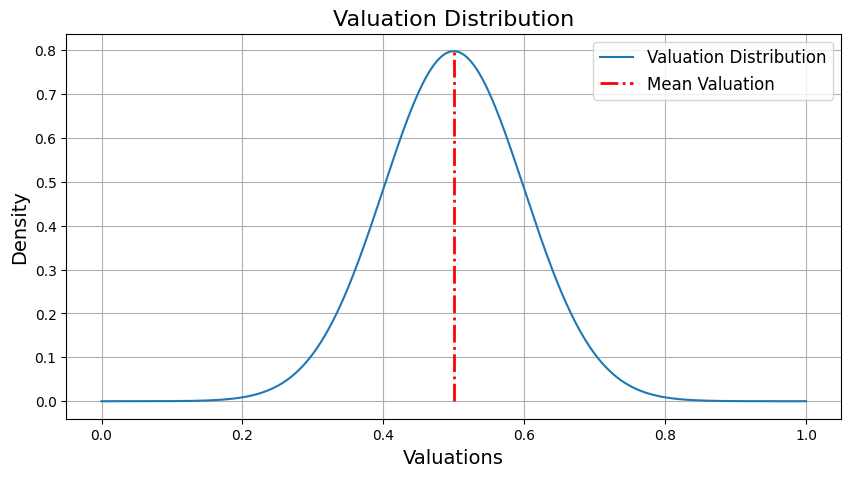

In [61]:
# Environment Configuration
env_config = {
    'valuation_mean': 0.5,  # Average customer valuation
    'valuation_std': 0.1,   # Standard deviation of customer valuations
    'demand_noise_std': 0  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

x = np.linspace(0, 1, 1000)
y = (1 / (env_config['valuation_mean'] * np.sqrt(2 * np.pi))) * np.exp(-(x - env_config['valuation_mean'])**2 / (2 * env_config['valuation_std']**2))

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Valuation Distribution', color='#1f77b4')  # Colore blu chiaro
plt.vlines(0.5, color='red', lw=2, ls='-.', ymin=0, ymax=max(y), label='Mean Valuation')  # Linea verticale rossa
plt.title('Valuation Distribution', fontsize=16)
plt.xlabel('Valuations', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)


# Agent configuration
agent_params = {
    'confidence_bound': 1,  # UCB exploration parameter
    'prices': [0,0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1]
}

print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f"UCB confidence bound: {agent_params['confidence_bound']}")

# set random seed for reproducibility
np.random.seed(42) 

Theoretical analysis of the optimal price, performed before running the agent

In [19]:
# Theoretical Analysis: Calculate optimal price and expected revenues
print("=== Theoretical Analysis ===")

# For each price, calculate the theoretical expected revenue
theoretical_revenues = []
for price in agent_params['prices']:
    # Expected demand probability (without noise)
    demand_prob = 1 - valuation_dist.cdf(price)
    expected_revenue = price * demand_prob
    theoretical_revenues.append(expected_revenue)
    print(f"Price {price:}: P(buy) = {demand_prob:.3f}, E[Revenue] = {expected_revenue:.2f}")

# Find the optimal price theoretically
optimal_idx = np.argmax(theoretical_revenues)
optimal_price = agent_params['prices'][optimal_idx]
optimal_revenue = theoretical_revenues[optimal_idx]

print(f"\nOptimal price (theoretical): {optimal_price}")
print(f"Optimal expected revenue: {optimal_revenue:.2f}")

# Store optimal information for later comparison
optimal_info = {
    'price': optimal_price,
    'price_idx': optimal_idx,
    'expected_revenue': optimal_revenue,
    'theoretical_revenues': theoretical_revenues
} 

=== Theoretical Analysis ===
Price 0: P(buy) = 1.000, E[Revenue] = 0.00
Price 0.1: P(buy) = 1.000, E[Revenue] = 0.10
Price 0.2: P(buy) = 0.999, E[Revenue] = 0.20
Price 0.3: P(buy) = 0.977, E[Revenue] = 0.29
Price 0.4: P(buy) = 0.841, E[Revenue] = 0.34
Price 0.5: P(buy) = 0.500, E[Revenue] = 0.25
Price 0.6: P(buy) = 0.159, E[Revenue] = 0.10
Price 0.7: P(buy) = 0.023, E[Revenue] = 0.02
Price 0.8: P(buy) = 0.001, E[Revenue] = 0.00
Price 0.9: P(buy) = 0.000, E[Revenue] = 0.00
Price 1: P(buy) = 0.000, E[Revenue] = 0.00

Optimal price (theoretical): 0.4
Optimal expected revenue: 0.34


# Run UCB Simulation


=== Running UCB1 Pricing Simulation ===

Running simulation number 1 for 100000 rounds...
Simulation completed!
Total revenue: 32558.00
Average revenue per round: 0.33
Agent's best price: 0.4 (avg revenue: 0.34)
Theoretical optimal: 0.4 (expected revenue: 0.34)


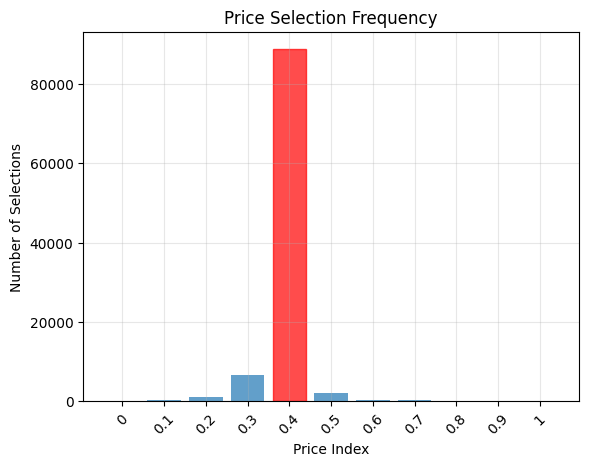

In [20]:
# Run UCB1 Pricing Simulation
print("\n=== Running UCB1 Pricing Simulation ===")

T = 100000  # Number of rounds
selected_prices = []
revenues = []
sales = []
cumulative_revenue = []

total_revenue = 0
n_simulations = 1  # Number of simulations run

best_prices = []
for sim in range(n_simulations):
    print(f"\nRunning simulation number {sim + 1} for {T} rounds...")

    # Create the stochastic environment
    env = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist,
        demand_noise_std=env_config['demand_noise_std']
    )

    # Create the UCB1 pricing agent
    agent = UCB1PricingAgent(**agent_params)

    for t in range(T):
        # Agent selects a price using UCB1
        price = agent.select_price()
        price_idx = agent.current_price_idx
        
        # Environment simulates customer behavior
        sale_made, revenue = env.simulate_round(price)
        
        # Agent updates its statistics
        agent.update(sale_made, revenue)
        
        # Record results
        selected_prices.append(price)
        revenues.append(revenue)
        sales.append(sale_made)
        total_revenue += revenue
        cumulative_revenue.append(total_revenue)
        
        # Print progress every 100 rounds
        # if (t + 1) % 100 == 0:
        #     avg_revenue = total_revenue / (t + 1)
        #     print(f"Round {t+1:4d}: Avg Revenue = {avg_revenue:.2f}, Current Price = {price}")

    print(f"Simulation completed!")
    print(f"Total revenue: {total_revenue:.2f}")
    print(f"Average revenue per round: {total_revenue/T:.2f}")

    # Agent's final statistics
    best_price, best_avg_revenue = agent.get_best_price()
    best_prices.append(best_price)
    print(f"Agent's best price: {best_price} (avg revenue: {best_avg_revenue:.2f})")
    print(f"Theoretical optimal: {optimal_price} (expected revenue: {optimal_revenue:.2f})")


price_counts = np.bincount([agent_params['prices'].index(p) for p in selected_prices], minlength=len(agent_params['prices']))
bars = plt.bar(range(len(agent_params['prices'])), price_counts, alpha=0.7)
bars[optimal_idx].set_color('red')  # Highlight optimal price
plt.xlabel('Price Index')
plt.ylabel('Number of Selections')
plt.title('Price Selection Frequency')
plt.xticks(range(len(agent_params['prices'])), [f'{p}' for p in agent_params['prices']], rotation=45)
plt.grid(True, alpha=0.3)

In [21]:
# Performance Analysis
print("\n=== Performance Analysis ===")

# Calculate regret
optimal_revenue_per_round = optimal_revenue
theoretical_total = optimal_revenue_per_round * T
regret_per_round = [optimal_revenue_per_round - revenues[t] for t in range(T)]
cumulative_regret = np.cumsum(regret_per_round)
final_regret = cumulative_regret[-1]

print(f"Theoretical optimal total revenue: {theoretical_total:.2f}")
print(f"Actual total revenue: {total_revenue:.2f}")
print(f"Total regret: {final_regret:.2f}")
print(f"Regret percentage: {100 * final_regret / theoretical_total:.2f}%")

# Price selection frequency
price_counts = np.bincount([agent_params['prices'].index(p) for p in selected_prices], minlength=len(agent_params['prices']))
print(f"\nPrice selection frequency:")
for i, (price, count) in enumerate(zip(agent_params['prices'], price_counts)):
    percentage = 100 * count / T
    marker = " ← OPTIMAL" if i == optimal_idx else ""
    print(f"  Price {price:}: {count:4d} times ({percentage:5.1f}%){marker}")

# Store results for visualization
results = {
    'selected_prices': selected_prices,
    'revenues': revenues,
    'sales': sales,
    'cumulative_revenue': cumulative_revenue,
    'cumulative_regret': cumulative_regret,
    'price_counts': price_counts,
    'total_revenue': total_revenue,
    'final_regret': final_regret
}


=== Performance Analysis ===
Theoretical optimal total revenue: 33653.79
Actual total revenue: 32558.00
Total regret: 1095.79
Regret percentage: 3.26%

Price selection frequency:
  Price 0:  186 times (  0.2%)
  Price 0.1:  362 times (  0.4%)
  Price 0.2:  987 times (  1.0%)
  Price 0.3: 6589 times (  6.6%)
  Price 0.4: 88702 times ( 88.7%) ← OPTIMAL
  Price 0.5: 2101 times (  2.1%)
  Price 0.6:  310 times (  0.3%)
  Price 0.7:  205 times (  0.2%)
  Price 0.8:  186 times (  0.2%)
  Price 0.9:  186 times (  0.2%)
  Price 1:  186 times (  0.2%)


# Plot the results


=== Generating Visualizations ===


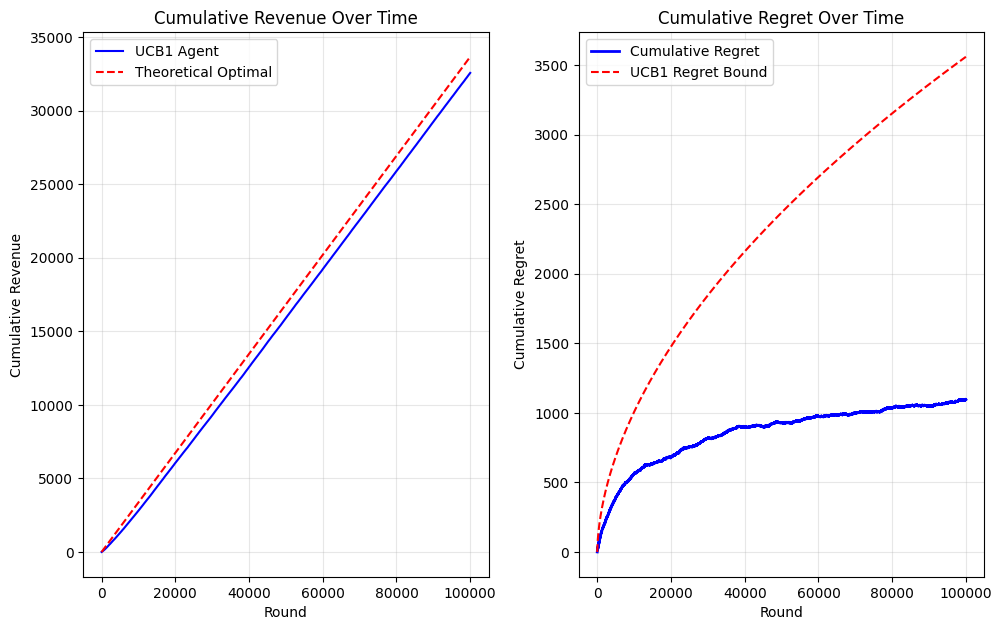

In [65]:
# Visualization
print("\n=== Generating Visualizations ===")

# Titoli delle visualizzazioni disponibili
available_titles = {
    'Cumulative Revenue Over Time': 1,
    'Cumulative Regret Over Time': 2,
    'Price Selection Frequency': 3,
    'Average Revenue by Price': 4,
    'Price Selection (Last 200 Rounds)': 5,
    'Customer Valuation Distribution': 6
}

# Titoli dei grafici che vuoi visualizzare
selected_titles = [
    'Cumulative Revenue Over Time', 
    'Cumulative Regret Over Time'
    # Aggiungi qui i titoli che vuoi visualizzare
]

# Definisci il layout per i subplots
plt.figure(figsize=(15, 12))

# 1. Cumulative Revenue over Time
if 'Cumulative Revenue Over Time' in selected_titles:
    plt.subplot(2, 3, available_titles['Cumulative Revenue Over Time'])
    plt.plot(cumulative_revenue, 'b-', label='UCB1 Agent')
    plt.plot([0, T], [0, theoretical_total], 'r--', label='Theoretical Optimal')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Revenue')
    plt.title('Cumulative Revenue Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 2. Cumulative Regret over Time
if 'Cumulative Regret Over Time' in selected_titles:
    plt.subplot(2, 3, available_titles['Cumulative Regret Over Time'])
    plt.plot(cumulative_regret, 'b-', linewidth=2, label='Cumulative Regret')
    
    # UCB1 regret bound: O(sqrt(K log T) T)
    K = len(agent_params['prices'])
    ucb1_bound = np.sqrt(K * np.log(np.arange(1, T + 1))) * np.sqrt(np.arange(1, T + 1))
    plt.plot(np.arange(1, T + 1), ucb1_bound, 'r--', label='UCB1 Regret Bound')

    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.title('Cumulative Regret Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 3. Price Selection Frequency
if 'Price Selection Frequency' in selected_titles:
    plt.subplot(2, 3, available_titles['Price Selection Frequency'])
    bars = plt.bar(range(len(agent_params['prices'])), price_counts, alpha=0.7)
    bars[optimal_idx].set_color('red')  # Highlight optimal price
    plt.xlabel('Price Index')
    plt.ylabel('Number of Selections')
    plt.title('Price Selection Frequency')
    plt.xticks(range(len(agent_params['prices'])), [f'{p}' for p in agent_params['prices']], rotation=45)
    plt.grid(True, alpha=0.3)

# 4. Average Revenue by Price
if 'Average Revenue by Price' in selected_titles:
    plt.subplot(2, 3, available_titles['Average Revenue by Price'])
    plt.bar(range(len(agent_params['prices'])), agent.average_revenue, alpha=0.7, label='UCB1 Agent')
    plt.bar(range(len(agent_params['prices'])), theoretical_revenues, alpha=0.5, label='Theoretical', color='orange')
    plt.xlabel('Price Index')
    plt.ylabel('Average Revenue')
    plt.title('Average Revenue by Price')
    plt.xticks(range(len(agent_params['prices'])), [f'{p}' for p in agent_params['prices']], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

# 5. Price Selection Over Time (last 200 rounds)
if 'Price Selection (Last 200 Rounds)' in selected_titles:
    plt.subplot(2, 3, available_titles['Price Selection (Last 200 Rounds)'])
    recent_prices = selected_prices[-200:]
    recent_rounds = range(T-200, T)
    plt.plot(recent_rounds, recent_prices, 'bo-', alpha=0.6, markersize=3)
    plt.axhline(y=optimal_price, color='r', linestyle='--', label=f'Optimal Price ({optimal_price})')
    plt.xlabel('Round')
    plt.ylabel('Selected Price')
    plt.title('Price Selection (Last 200 Rounds)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 6. Customer Valuation Distribution
if 'Customer Valuation Distribution' in selected_titles:
    plt.subplot(2, 3, available_titles['Customer Valuation Distribution'])
    x_vals = np.linspace(0, 1, 1000)
    pdf_vals = valuation_dist.pdf(x_vals)
    plt.plot(x_vals, pdf_vals, 'g-', linewidth=2, label='Valuation Distribution')
    plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal Price ({optimal_price})')
    plt.axvline(x=env_config['valuation_mean'], color='orange', linestyle=':', label=f'Mean Valuation ({env_config["valuation_mean"]})')
    plt.xlabel('Customer Valuation')
    plt.ylabel('Probability Density')
    plt.title('Customer Valuation Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Organizza il layout e mostra i grafici
plt.tight_layout()
plt.show()


## UCB1 Pricing Strategy - Summary

### Algorithm Overview

The **UCB1 (Upper Confidence Bound)** algorithm treats pricing as a multi-armed bandit problem where:
- Each **price** is an **arm** in the bandit
- Each **arm pull** is setting that price for one customer
- The **reward** is the revenue generated (price × sale_indicator)

### UCB1 Formula

For each price $p_i$ at time $t$, the UCB1 value is:

$$UCB_t(p_i) = \bar{r}_{t}(p_i) + c \sqrt{\frac{\ln t}{n_t(p_i)}}$$

Where:
- $\bar{r}_{t}(p_i)$ = average revenue from price $p_i$ up to time $t$
- $c$ = confidence parameter (exploration vs exploitation trade-off)
- $n_t(p_i)$ = number of times price $p_i$ has been used
- $t$ = current time step

### Key Properties

1. **Exploration vs Exploitation**: The algorithm balances trying promising prices (exploitation) with exploring uncertain prices (exploration)

2. **Confidence Bounds**: Higher uncertainty (fewer observations) leads to higher UCB values, encouraging exploration

3. **Convergence**: As $t \to \infty$, the algorithm converges to the optimal price with high probability

4. **Regret Bound**: UCB1 achieves $O(\sqrt{K \log T})$ regret, where $K$ is the number of prices and $T$ is the time horizon

### Stochastic Environment

The environment models customer behavior with:
- **Valuation Distribution**: Customers have valuations drawn from $\mathcal{N}(\mu, \sigma^2)$
- **Purchase Decision**: Customer buys if valuation ≥ price
- **Demand Probability**: $P(\text{purchase}) = P(\text{valuation} \geq \text{price}) + \text{noise}$
- **Revenue**: price × purchase_indicator

=== Sensitivity Analysis: UCB Confidence Parameter ===

Testing confidence parameter: 0.5
  Final regret: 76.44
  Total revenue: 260.10

Testing confidence parameter: 1.0
  Final regret: 133.14
  Total revenue: 203.40

Testing confidence parameter: 2.0
  Final regret: 180.54
  Total revenue: 156.00

Testing confidence parameter: 4.0
  Final regret: 193.74
  Total revenue: 142.80


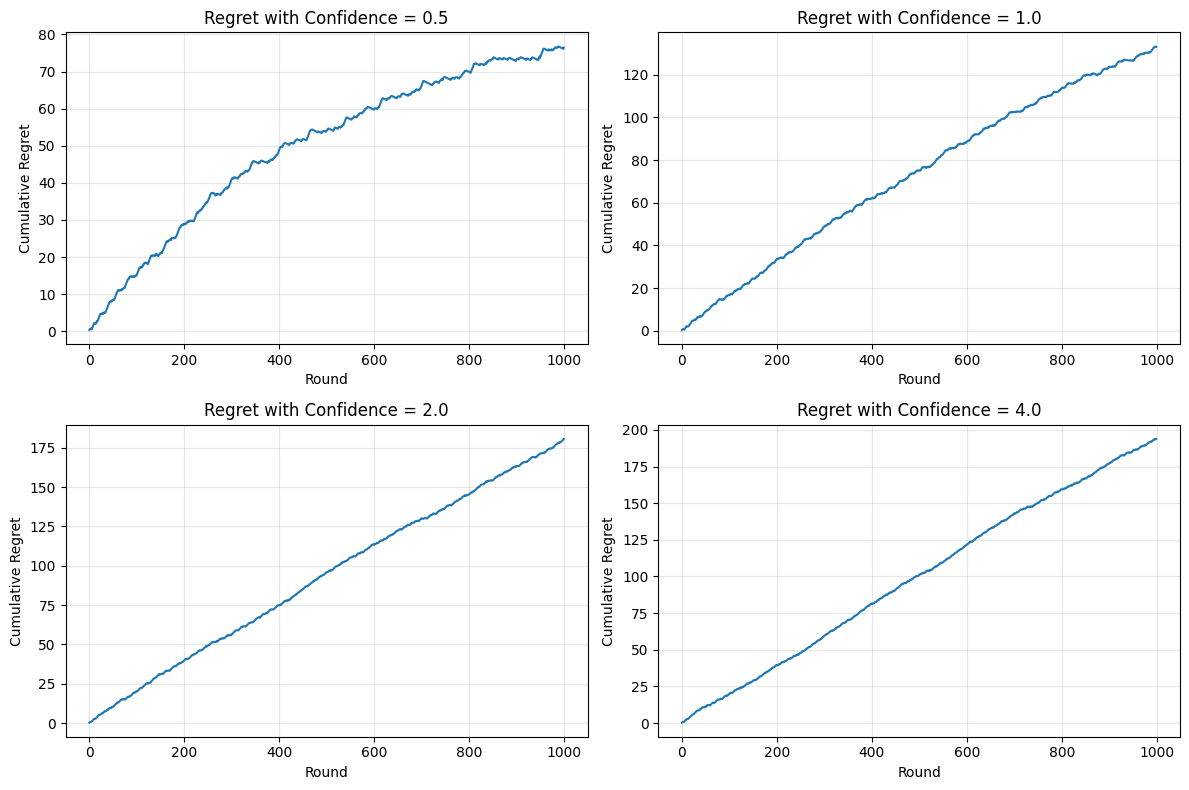


=== Experiment Summary ===
Confidence | Final Regret | Total Revenue
----------------------------------------
   0.5     |    76.44    |    260.10   
   1.0     |   133.14    |    203.40   
   2.0     |   180.54    |    156.00   
   4.0     |   193.74    |    142.80   

Best configuration: confidence = 0.5 (lowest regret)


In [23]:
# Experiment: Effect of Different UCB Parameters
print("=== Sensitivity Analysis: UCB Confidence Parameter ===")

confidence_values = [0.5, 1.0, 2.0, 4.0]
experiment_results = []

plt.figure(figsize=(12, 8))

for i, confidence in enumerate(confidence_values):
    print(f"\nTesting confidence parameter: {confidence}")
    
    # Create new agent with different confidence parameter
    test_agent = UCB1PricingAgent(prices=agent_params['prices'], confidence_bound=confidence)
    test_cumulative_regret = []
    test_total_revenue = 0
    
    # Run shorter simulation for comparison
    T_test = 1000
    for t in range(T_test):
        price = test_agent.select_price()
        sale_made, revenue = env.simulate_round(price)
        test_agent.update(sale_made, revenue)
        
        test_total_revenue += revenue
        regret = optimal_revenue_per_round - revenue
        if t == 0:
            test_cumulative_regret.append(regret)
        else:
            test_cumulative_regret.append(test_cumulative_regret[-1] + regret)
    
    experiment_results.append({
        'confidence': confidence,
        'cumulative_regret': test_cumulative_regret,
        'total_revenue': test_total_revenue,
        'final_regret': test_cumulative_regret[-1]
    })
    
    # Plot cumulative regret for this configuration
    plt.subplot(2, 2, i+1)
    plt.plot(test_cumulative_regret, label=f'c = {confidence}')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.title(f'Regret with Confidence = {confidence}')
    plt.grid(True, alpha=0.3)
    
    print(f"  Final regret: {test_cumulative_regret[-1]:.2f}")
    print(f"  Total revenue: {test_total_revenue:.2f}")

plt.tight_layout()
plt.show()

# Summary of experiment
print(f"\n=== Experiment Summary ===")
print("Confidence | Final Regret | Total Revenue")
print("-" * 40)
for result in experiment_results:
    print(f"{result['confidence']:^10.1f} | {result['final_regret']:^11.2f} | {result['total_revenue']:^12.2f}")

best_config = min(experiment_results, key=lambda x: x['final_regret'])
print(f"\nBest configuration: confidence = {best_config['confidence']} (lowest regret)")